In [36]:
import pandas as pd
import numpy as np
import networkx as nx
from pyvis import network as net
from pyvis.network import Network
import random
#from serpapi import GoogleScholarSearch
import json
import requests

# Creation of DataFarme

In [ ]:
#import given dataframe nodes
nodes = pd.read_csv("Data/nodes.csv")

nodes['author_id'] = None
nodes['cited_by'] = None 
nodes['interests'] = None
nodes.to_csv('Data/nodes.csv', index=False)

edges = pd.DataFrame(columns=['author1','author2']) 
edges.to_csv('Data/edges.csv', index=False)

## ES 1
A partire da nodes.csv, utilizzare la libreria Python SerpAPI per scaricare, per ciascuno dei 7 autori elencati:
- author_id: ID identificativo del profilo Google Scholar
- cited_by: numero totale di citazioni ricevute
- interests: elenco degli interessi di ciascun autore
Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per aggiornare il file originale con apposite colonne e memorizzarlo nella cartella /data.
## 2. Analisi dei Coautori tramite SerpAPI su Google Scholar

### a. Ottenere i Coautori dei 7 Autori Principali

Per ciascuno dei 7 autori, utilizzare il suo ID per accedere al relativo profilo Google Scholar e scaricare l'elenco dei suoi coautori utilizzando SerpAPI. Con tale elenco di nomi:;

#### a.1. Ricerca dei Coautori su Google Scholar

Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che corrisponde a ciascun nome nella lista di coautori. Per ogni risultato, salvare le informazioni come `name`, `affiliations`, `author_id`, `cited_by`, e `interests` in un nuovo DataFrame contenente tutte queste informazioni relative ai coautori dei 7 autori originari.

### b. Concatenazione dei DataFrame

Concatenare il DataFrame contenente le informazioni sui 7 autori principali con quello dei coautori generato al punto 2a in un unico DataFrame.

### c. Creazione del DataFrame delle Relazioni di Co-Authorship

Creare un terzo DataFrame con le colonne `author1` e `author2` che rappresenta le co-authorship. In questo DataFrame, una riga rappresenta un arco di coauthorship tra due autori. La co-authorship è binaria, non pesata.

#### Esempio

Se David La Barbera e Michael Soprano sono coautori, una riga del DataFrame creato al punto 2c rappresenterà questa relazione.

### Risultati Finali

A questo punto, saranno stati prodotti due DataFrame:

- Uno contenente le informazioni relative agli autori (originali + i relativi coautori), con le colonne `name`, `affiliations`, `cited_by`, `interests`. Salvare come `nodes.csv` nella cartella `/data` tale DataFrame.

- Un altro per le relazioni di co-authorship dai 7 autori principali verso i relativi coautori, con colonne `author1` e `author2`. Salvare come `edges.csv` nella cartella `/data` tale DataFrame.

In [ ]:
#key in use right now
#apikey = "9e35e5273396934a1f34354188e7b0509d31c9c99833802e8128d156b17a8b1d"

In [ ]:
#overwrite the row of nodes with df_update in the right position
#if the author given isn't in nodes, then it will get concatenated

def update_nodes(df_update, nodes):
    
    nodesMod = pd.read_csv(r'Data/nodes.csv') #read nodes.csv updated
    
    print('nome: ', df_update["name"][0])

    #check if the author is in nodes using attribute name as parameter
    if (nodesMod["name"] == df_update["name"][0]).any():
        print('già presente in nodes')

        #if author is already in nodes update the present row with df_update (may not be completed)
        for index in range(len(nodes)):
            #sroll down all the names in nodes and compare it with the df_update one
            if nodes["name"][index] == df_update["name"][0]:
                print('sta sovrascrivendo con: ', df_update.iloc[0])

                nodesMod.iloc[index]=df_update.iloc[0] #replace the row of nodesMod with df_update
                nodesMod.to_csv(r'Data/nodes.csv', index=False) #overwrite the csv with the one having the new row
    else:
        #if the author isn't already in nodes, concatenates it
        nodesMod = pd.concat([nodesMod, df_update], ignore_index=True)
        nodesMod.to_csv(r'Data/nodes.csv', index=False) #overwrite the csv by adding df_update at the end
            

In [ ]:
# author_profile update nodes.csv with name, affiliations, author_id, cited_by, interests of a given author
# this function requires the name and affiliation of the author to search for and nodes (it contains only the original authors)

def author_profile(apiKey, name, affiliation, nodes):

    base_url = "https://serpapi.com/search"

    #search among scholar profiles for the one with the given name
    params = {
        "api_key": apiKey,
        "engine": "google_scholar_profiles",
        "hl": "en",
        "mauthors": name
    }

    #save the request response in json
    response = requests.get(base_url, params=params)
    results = response.json()
    
    #save the results in a json
    name_json = "json/" + name + ".json"
    with open(name_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    
    notFound = True #used to see if among the profiles found there is one with the same name and affiliation as those given
    indexProfile = 0 #if correct profile is found, indexProfile change with the corresponding index, otherwise take profile 0

    #scroll through profiles to verifies if the profile found is the one that we are searching for and save the corrisponding index
    for index, profile in enumerate(results["profiles"]):
        if (name in profile["name"]):
            #setti l'indice solo se è la prima volta che entri se e gia cambiato non entri
            if indexProfile == 0:
                indexProfile = index
            if (affiliation in profile["affiliations"]):
                indexProfile = index #change the original index
                notFound = False #we have found the searched profile
                break #the desired profile has been found -> no need to continue
    
    interests = ' '  #set interest as "empty"
    prifileDesired = results["profiles"][indexProfile] #json with all the information of the profile

    authorId = prifileDesired["author_id"] 
    citedBy = prifileDesired["cited_by"]
        
    #not all profiles have the key 'interests' in the dict (coauthors)
    if 'interests' in prifileDesired:
        if prifileDesired["interests"] != '': #if key interest exist but it is empty 
            interests = ", ".join([i['title'] for i in prifileDesired["interests"]])  # select only titles for each interest, join to remove the square brackets (now seen as a single string instead of a list)
    else:
        #create a new key in the dict and set it as a empty string
        prifileDesired["interests"] = ' '
    
    #if we found the profile:
    if not notFound: 
        #create a new row of the dataframe with all the information needed and return it
        df_update = pd.DataFrame({'name': [name],'affiliations': [affiliation],'author_id': [authorId],'cited_by': [citedBy],'interests': [interests]})
        
        #adds the author to nodes if it is not already present
        update_nodes(df_update, nodes)
    
    #if there is no profile with the correct name and affiliation, we've taken the first one (we've already taken the necessary data)
    else:
        #create a new row of the dataframe with all the information needed and return it (affiliation is a string empty)
        df_update = pd.DataFrame({'name': [name],'affiliations': " ",'author_id': [authorId],'cited_by': [citedBy],'interests': [interests]})
        
        #adds the author to nodes if it is not already present
        update_nodes(df_update, nodes)

In [ ]:

'''
def nodes_information(apikey, df):
    
    #iterate the row of the given df, for each one makes the call to the author_profile
    for index, row in df.iterrows():
        author_data = author_profile(apikey, row['name'], row['affiliations'])
 '''       

## Main es 1

In [ ]:
'''
#get the final dataframe of the 7 originals authors with name, affiliations, author_id, cited_by, interests 
nodes_information(apikey, nodes)
'''

In [ ]:
#get_profile_coauthors find all coauthors of the given author and save them in nodes and edges
#for every author check that the dict's key needed exist and if they are empty

def get_profile_coauthors(apiKey, authorID, nodes):
    
    base_url = "https://serpapi.com/search"

    #search among scholar profiles for the one with the given author_id
    params = {
        "api_key": apiKey,
        "engine": "google_scholar_author",
        "hl": "en",
        "author_id": authorID
    }
    
    #save the request response in json
    response = requests.get(base_url, params = params)
    results = response.json()
    
    #save the results in a json
    name_json = "json/"+authorID + ".json"
    with open(name_json, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    
    edges = pd.read_csv(r'Data/edges.csv')  #read edges.csv
    
    authorName = results["author"] #saves the name of the author given as input with the Id
    
    for coauthor in results['co_authors']:  #for each coauthor
        
        #create a couples author-coauthor in both ways (used to check if it is already present in edges.csv)
        edgesCopules = [(authorName["name"], coauthor['name']), (coauthor['name'], authorName["name"])]
        
        notFound = True #the couple isn't already present
        
        #cycles through edges.csv and check if the pair to insert, edgesCopules, is already present (in both directions)
        for index, row in edges.iterrows():
            if (row['author1'], row['author2']) in edgesCopules or (row['author2'], row['author1']) in edgesCopules:
                #there is already a link between author and coauthor or vice versa
                notFound = False #the couple is present
        
        #if the pair is not present it is concatenated to edegs.csv
        if(notFound):
            row_edge = pd.DataFrame([{'author1' : authorName["name"], 'author2': coauthor['name']}])
            edges = pd.concat([edges, row_edge], ignore_index=True)

        #add a coauthor to nodes:
        #check if 'affiliations' is a key on the coauthor dict:
        if 'affiliations' in coauthor:
            if coauthor['affiliations'] == '': #check if affiliation is empty
                author_profile(apiKey, coauthor['name'], '', nodes) #calls author_profile with the name of the co-author and empty affiliation
            else:
                author_profile(apiKey, coauthor['name'], coauthor['affiliations'], nodes)#calls author_profile with the name and affiliation
                
        #if the coauthor's dict hasn't 'affiliations' key create it and calls author_profile
        else:
            coauthor['affiliations'] = " "
            author_profile(apiKey, coauthor['name'], coauthor['affiliations'], nodes)
    
    #when all coauthors of the main author have been insert in nodes and concatenated into edges (if not already present), overwrites edges 
    edges.to_csv(r'Data/edges.csv', index=False)

## Main es 2

In [ ]:
'''

#read nodes.csv (!!should only contain the names and affiliations of the 7 original authors)
nodes = pd.read_csv(r'Data/nodes.csv') 

#cycle the authors and takes their coauthors (and their required information), adds them to nodes and to edges with the relevant arch
for author in nodes["author_id"]:
    get_profile_coauthors(apikey, author, nodes)
'''



# Parte 3
Usare il due dataset per creare grafico indiretto:
a. Generare un grafo indiretto che ne rappresenta le informazioni contenute.
Salvare (serializzare) il grafo in locale nella cartella /graphs .
b. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le
seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20, giallo per nodi con grado maggiore di 20. Inoltre, per ciascun nodo visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella /visualizations.




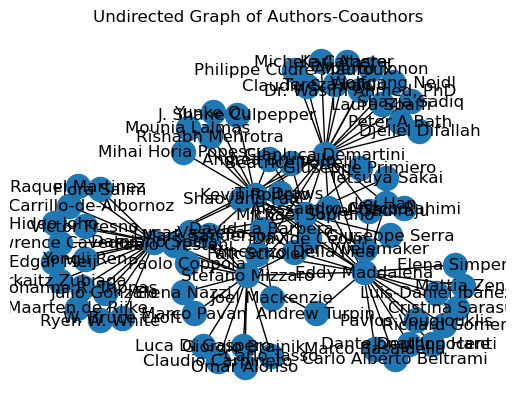

In [45]:
import matplotlib.pyplot as plt
# Creating an empty graph
G = nx.Graph()
# Read CSV files
nodes = pd.read_csv('Data/nodes.csv')
edges = pd.read_csv('Data/edges.csv')

# Add nodes to the graph from the 'nodes' DataFrame
nodes_list = nodes['name'].tolist()
G.add_nodes_from(nodes_list)

# Add edges to the graph from the 'edges' DataFrame
edges_list = edges[['author1', 'author2']].values.tolist()
G.add_edges_from(edges_list)

# Add a title to the graph
plt.title("Undirected Graph of Authors-Coauthors")

# Draw the graph with labels
nx.draw(G, with_labels=True)


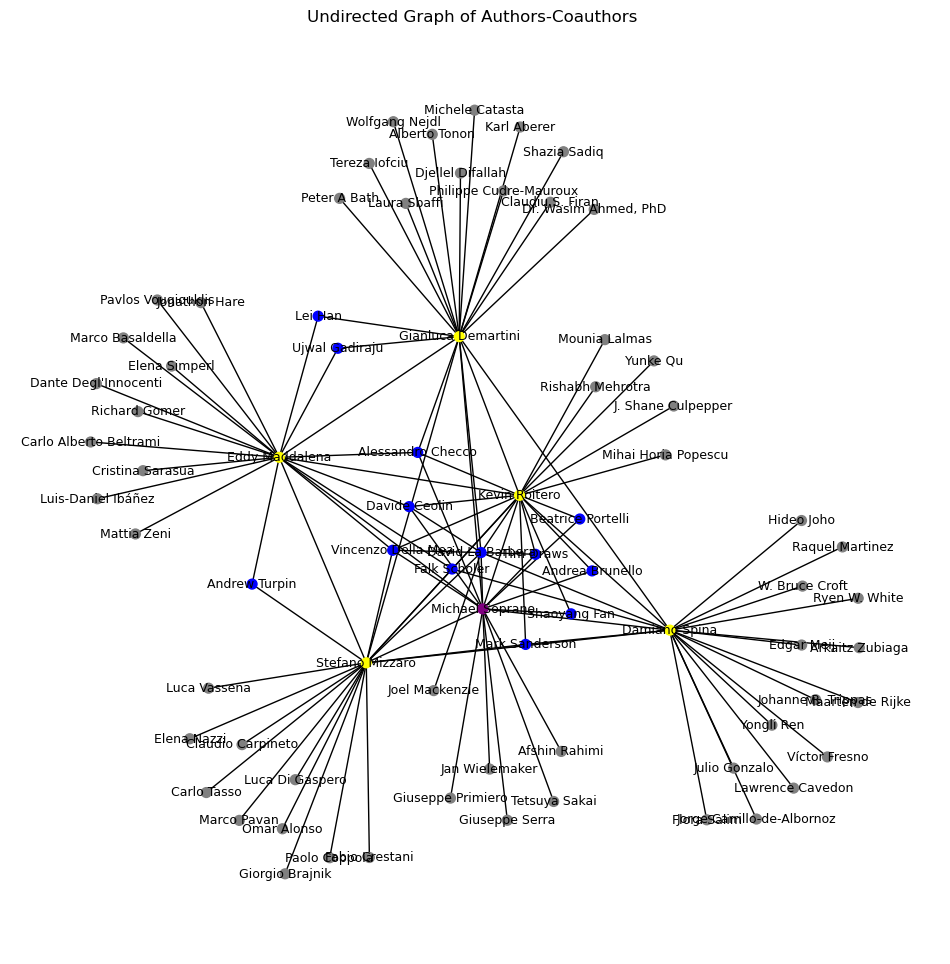

In [46]:

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

def colorazione_nodi(G):
    # Takes a graph as input and calculates the degree of nodes. Subsequently, it assigns a specific color to each
    # node based on its degree and saves this information in a dictionary called 'colori_specifici', returning it
    # as the result of the function.

    # Degree calculation
    degrees = dict(G.degree())
    colori_specifici = {}
    for nodo, grado in degrees.items():
        if grado == 1:
            # Gray color
            colori_specifici[nodo] = 'gray'
        elif grado in range(2, 10):
            # Blue color
            colori_specifici[nodo] = 'blue'
        elif grado in range(11, 20):
            # Purple color
            colori_specifici[nodo] = 'purple'
        elif grado:
            # Yellow color
            colori_specifici[nodo] = 'yellow'
    return colori_specifici

def stampaGrafo(DatiPerVisualizzazione):
    # Simply takes two values saved in DatiPerVisualizzazione, which are the graph and node colors,
    # and uses these two data to draw the graph.

    # Visualize the graph
    plt.figure(3, figsize=(12, 12))
    plt.title("Undirected Graph of Authors-Coauthors ")
    nx.draw(DatiPerVisualizzazione[0], with_labels=True, node_color=DatiPerVisualizzazione[1].values(), node_size=50, font_size=9)

def graficoIndirettoColorato():
    # This function simply returns two values: the graph with nodes and edges and a dictionary with node colors,
    # which is returned by the 'colorazione_nodi()' function.

    # Creating an empty graph
    G = nx.Graph()
    # Read CSV files
    nodi = pd.read_csv('Data/nodes.csv')
    edges = pd.read_csv('Data/edges.csv')

    # Add nodes to the graph
    nodes = nodi['name'].tolist()
    G.add_nodes_from(nodes)

    # Add edges to the graph
    edges = edges[['author1', 'author2']].values.tolist()
    G.add_edges_from(edges)
    coloreNodi = colorazione_nodi(G)

    return G, coloreNodi

def salvaGrafico(graficoDaSalvare, DatiGrafo):
    # This function takes two values as input, 'graficoDaSalvare' and 'DatiGrafo'. 'graficoDaSalvare' is used only to
    # distinguish which of the two graphs to save. 'DatiGrafo' contains the graph and the dictionary with the
    # node colors.
    if graficoDaSalvare == 1:
        plt.savefig("visualizations/first_graph.pdf")
        nt = net.Network(height="100%",
                         width="100%",
                         bgcolor="#222222",
                         font_color="white")

        nt.barnes_hut()  # use Barnes-Hut algorithm
        nt.from_nx(DatiGrafo[0])
        neibor_map = nt.get_adj_list()
        for node in nt.nodes:
            node['color'] = DatiGrafo[1][node['id']]
        nt.save_graph("visualizations/interactive_first_graph.html")
    else:

        plt.savefig("visualizations/extended_graph.pdf")
        nt = net.Network(height="100%",
                         width="100%",
                         bgcolor="#222222",
                         font_color="white")
        nt.barnes_hut()  # use Barnes-Hut algorithm
        nt.from_nx(DatiGrafo[0])
        neibor_map = nt.get_adj_list()
        for node in nt.nodes:
            node['color'] = DatiGrafo[1][node['id']]
        nt.save_graph("visualizations/interactive_extended_graph.html")

DatiGrafo1 = graficoIndirettoColorato()
stampaGrafo(DatiGrafo1)
salvaGrafico(1, DatiGrafo1)


## Es 4
Generarne un secondo dove il numero di nodi è lo stesso, mentre il numero di
archi è aumentato di 50 utilizzando la tecnica del Preferential Attachment.
Salvare il grafo in locale nella cartella /graphs.


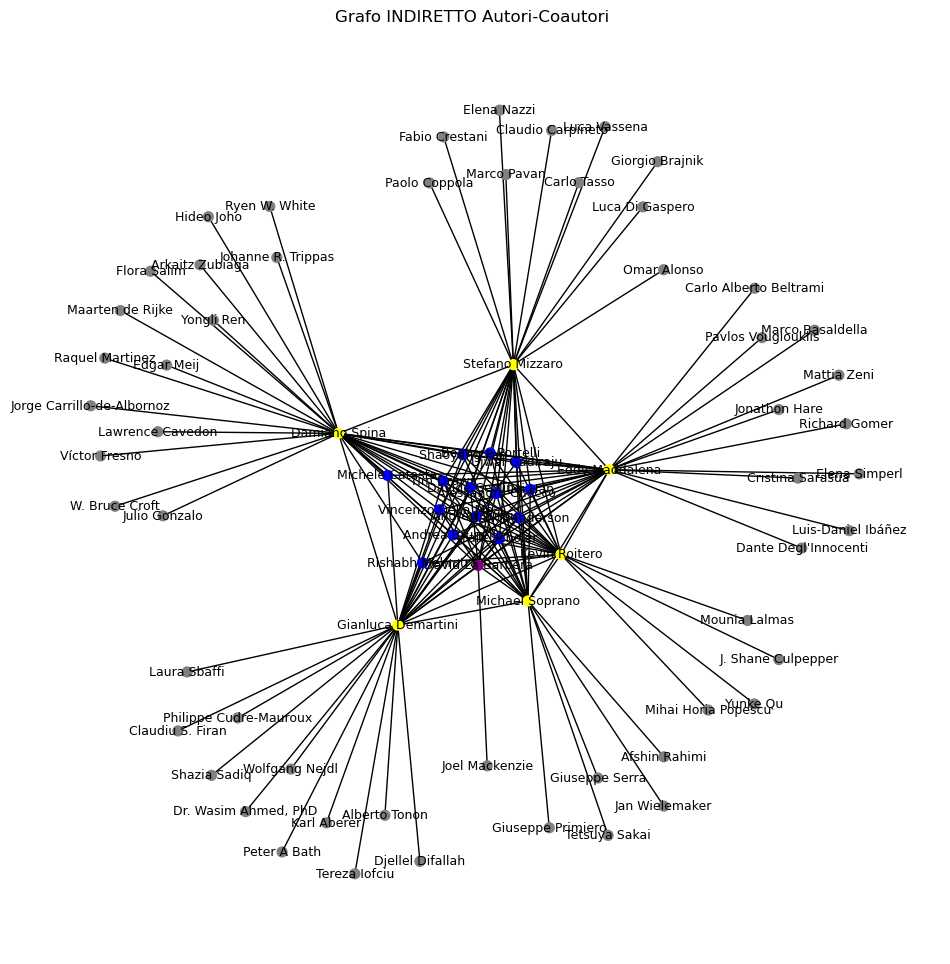

In [38]:
import matplotlib.pyplot as plt
import networkx as nx

# This function takes two values, G and n. G is the input graph, and n is the number of edges to be added using the
# preferential attachment technique. The function returns a list of the first n edges, extracted from the list of triples
# returned by the preferential_attachment(G) function, sorted based on the probability of edge creation.
def preferential_attachment_primi_n_valori(G, n):
    pa = nx.preferential_attachment(G)
    lista_ordinata = sorted(pa, key=lambda x: x[2], reverse=True)
    # Display the results
    lista_ordinata_di_n_valori = lista_ordinata[:n]
    lista_ordinata_di_n_valori = [(x[0], x[1]) for x in lista_ordinata_di_n_valori]
    return lista_ordinata_di_n_valori

def graficoConNodiAggiunti():
    # Creating an empty graph
    G = nx.Graph()
    # Read CSV files
    nodi = pd.read_csv('Data/nodes.csv')
    edges = pd.read_csv('Data/edges.csv')
    # Add nodes to the graph
    nodes = nodi['name'].tolist()
    G.add_nodes_from(nodes)
    # Add edges to the graph
    edges = edges[['author1', 'author2']].values.tolist()
    G.add_edges_from(edges)
    # Save the edges created by the preferential_attachment_primi_n_valori(G, 50) function.
    archiPA = preferential_attachment_primi_n_valori(G, 50)
    # Add edges to the graph
    G.add_edges_from(archiPA)
    # Color nodes and draw the graph
    ColoriNodi = colorazione_nodi(G)

    return G , ColoriNodi


DatiGrafo2 = graficoConNodiAggiunti()
stampaGrafo(DatiGrafo2)
salvaGrafico(2,DatiGrafo2)


## Es 5
Per entrambi i grafi prodotti calcolare:
1. Coefficiente di clustering medio
2. Centro del grafo
3. Raggio
4. Distanza Media
5. Transitività
6. Coefficienti Omega e Sigma, per stimare la “small-world-ness”
7. Riassumere le informazioni in un DataFrame, dove ogni riga rappresenta le informazioni relative ad un grafo, ed ogni colonna le informazioni  relative ad una misura calcolata per quel grafo. Salvare nella cartella /results tale DataFrame.


In [39]:
#  Calculate the requested measures for the graph and save it in a dictionary
def calculateMeasureGraph(G, graph_name):
    graph_measure =pd.DataFrame({
    'Graph':graph_name,
    'Coefficienti di Clustering Medio': nx.average_clustering(G),
    'Centro del Grafo': [nx.center(G)],
    'Raggio': nx.radius(G),
    'Distanza Media': nx.average_shortest_path_length(G),
    'Transitività': nx.transitivity(G),
    'Coefficiente Omega': nx.omega(G),
    'Coefficiente Sigma': nx.sigma(G)
    })
    return graph_measure



# Generate the first graph
data_first_graph=graficoIndirettoColorato()
first_graph = data_first_graph[0]
first_graph_centralities=calculateMeasureGraph(first_graph, "first_graph")

# Generate the extended graph
data_extended_graph=graficoConNodiAggiunti()
graph_preferential_attachment=data_extended_graph[0]
extended_graph_centralities=calculateMeasureGraph(graph_preferential_attachment, "graph_preferential_attachment")

# Part 7 concatanate the two dataFrame in a list save the dictionary in a csv
overall_measures = [first_graph_centralities,extended_graph_centralities]
overall_measures = pd.concat(overall_measures)
overall_measures.to_csv("results/overall_measures.csv", index=False)

## ES 6

#### Per entrambi i grafi prodotti calcolare per ogni nodo:
1. Degree Centrality
2. Betweenness Centrality
3. Closeness Centrality
4. Pagerank
5. HITS, per calcolare i valori di hubness e authority
6. Riassumere le due informazioni in un DataFrame per ciascun grafo, dove
ogni riga rappresenta le informazioni relative ad un nodo, ed ogni colonna le
informazioni relative ad una misura calcolata per quel nodo. Salvare nella
cartella /results tali DataFrame.


In [58]:
#extract the hubness value from hits
def hubness(G):
    hits_result=nx.hits(G)
    return hits_result[0]

#extract the authorities value from hits
def authorities(G):
    hits_result=nx.hits(G)
    return hits_result[1]

#  Calculate the requested measures for every node of the graph and save it in a dictionary
def calculateMeasureNode(G):
    Node_measure = pd.DataFrame (
        {'Node': list(G.nodes()),
         'Degree Centrality': list(nx.degree_centrality(G).values()),
         'Betweenness centrality': list(nx.betweenness_centrality(G).values()),
         'Closeness centrality': list(nx.closeness_centrality(G).values()),
         'PageRank': list(nx.pagerank(G).values()),
         'Hubness': list(hubness(G).values()),  # Hubness values
         'Authorities': list(authorities(G).values())  # Authorities values
         }
    )
    return Node_measure



#generate the two dataframe for the two graphthe results of the dataFrame
first_graph_centralities=calculateMeasureNode(first_graph)
extended_graph_centralities=calculateMeasureNode(graph_preferential_attachment)

#Part 6 generate the two csv to save the results of the dataFrame
first_graph_centralities.to_csv("results/first_graph_centralities.csv", index=False)
extended_graph_centralities.to_csv("results/extended_graph_centralities.csv", index=False)



                      Node  Degree Centrality  Betweenness centrality  \
0         David La Barbera           0.120000                0.038150   
1          Michael Soprano           0.240000                0.192511   
2            Kevin Roitero           0.266667                0.203640   
3          Stefano Mizzaro           0.266667                0.285225   
4            Damiano Spina           0.280000                0.345279   
..                     ...                ...                     ...   
71    Dante Degl'Innocenti           0.013333                0.000000   
72      Pavlos Vougiouklis           0.013333                0.000000   
73           Jonathon Hare           0.013333                0.000000   
74  Carlo Alberto Beltrami           0.013333                0.000000   
75           Richard Gomer           0.013333                0.000000   

    Closeness centrality  PageRank   Hubness             Authorities  
0               0.496689  0.033772  0.044330        